In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

In [2]:
from src import display
from src import data_transformer as dt

In [3]:
img_path = "data/VOCdevkit/VOC2012/JPEGImages/"
seed = 42
target_size = 224

In [4]:
train_json_path = "data/pascal_train2012.json"

In [5]:
id_cat, train_list = dt.load_pascal(train_json_path)

In [6]:
train_list = dt.rescale_bounding_boxes(train_list, target_size)

In [7]:
# Re-orginize
train_list = [[element[0], element[1], element[3], element[2]] for element in train_list]

In [8]:
example = train_list[3]
example

['2008_000023.jpg',
 ['person', 'person', 'person', 'bottle', 'tvmonitor'],
 [14, 14, 14, 4, 19],
 [[91, 16, 22, 33],
  [120, 16, 25, 31],
  [64, 17, 19, 29],
  [26, 43, 55, 141],
  [3, 0, 208, 117]]]

In [9]:
train_list[0]

['2008_000008.jpg',
 ['horse', 'person'],
 [12, 14],
 [[23, 44, 188, 169], [70, 22, 59, 63]]]

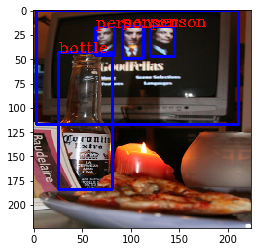

In [10]:
img_str = img_path + example[0]
img = display.read_img(img_str, target_size)

img = display.draw_boxes(img, example[3])
img = display.draw_text(img, example[1], example[3])
plt.imshow(img)
plt.show()

In [11]:
# Normalize BB to 0-1 and set the first elements to center scale
for element in train_list:
    for b in element[3]:
        b[0] = b[0] + b[1]/2
        b[0] = b[0] / target_size

        b[1] = b[1] + b[3]/2
        b[1] = b[1] / target_size

        b[2] = b[2] / target_size
        b[3] = b[3] / target_size

In [12]:
anchor_grid = [4, 2, 1] # Number of grid-elements per dimension
anchor_zooms = [0.7, 1.0, 1.3] # How much bigger/smaller each default box will be (percentage)
anchor_ratios = [(1.0, 1.0), (1.0, 0.5), (0.5, 1.0)] # Ratio between (width, height)

anchor_scales = [(anc*h, anc*w) for anc in anchor_zooms for (h,w) in anchor_ratios]
anchor_offsets = [1/(2*o) for o in anchor_grid]
num_boxes = len(anchor_scales)

In [13]:
anchor_x = [np.repeat(np.linspace(ao, 1-ao, ag), ag) for (ao, ag) in zip(anchor_offsets, anchor_grid)]
anchor_x = np.concatenate(anchor_x)

anchor_y = [np.tile(np.linspace(ao, 1-ao, ag), ag) for ao,ag in zip(anchor_offsets, anchor_grid)]
anchor_y = np.concatenate(anchor_y)

anchor_centers = np.repeat(np.stack([anchor_x, anchor_y], axis=1), num_boxes, axis=0)

In [14]:
anchor_sizes  = [np.array([[w/ag, h/ag] for _ in range(ag**2) for w, h in anchor_scales])
                 for ag in anchor_grid]
anchor_sizes = np.concatenate(anchor_sizes)

#bx, by, w, h
anchors = np.concatenate([anchor_centers, anchor_sizes], axis=1)

In [15]:
anchors = torch.from_numpy(anchors).float()

In [16]:
def center_2_hw(box):
    """
        Converting (bx, by, w, h) to (x1, y1, x2, y2)
    """
    
    return torch.cat(
        [box[:, 0:1] - box[:, 2:3]/2,
         box[:, 1:2] - box[:, 3:4]/2,
         box[:, 0:1] + box[:, 2:3]/2,
         box[:, 1:2] + box[:, 3:4]/2
         ], dim=1)

def intersect(anchors, ground_truth):
    max_xy = torch.min(anchors[:, None, 2:], ground_truth[None, :, 2:])
    min_xy = torch.max(anchors[:, None, :2], ground_truth[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_area(box): 
    area = (box[:, 2] - box[:, 0]) * (box[:, 3] - box[:, 1])
    return area

def jaccard(anchors, ground_truth):
    """
        Box with shape bx, by, w, h
    """
    
    temp_anchors, temp_ground_truth = center_2_hw(anchors), center_2_hw(ground_truth)
    intersection = intersect(temp_anchors, temp_ground_truth)
    union = box_area(temp_anchors).unsqueeze(1) + box_area(temp_ground_truth).unsqueeze(0) - intersection
    return intersection / union

In [17]:
device = "cuda"
seed = 42

In [18]:
max_overlaps = []
ground_truths = []
classes = []

for item in train_list:
    gt = np.vstack(item[3])
    gt = torch.from_numpy(gt).float()
    ground_truths.append(gt[None, :, :].to(device))
    
    jaccard_tensor = jaccard(anchors, gt)
    _, max_overlap = jaccard_tensor.max(0)
    
    max_overlaps.append(max_overlap.to(device))
    
    # NOTE: ADDING +1 since first element should be bakcground checks, need to be fixed later
    classes.append(torch.from_numpy(np.array(item[2])[None, :]).to(device) + 1)

In [19]:
def flatten_conv(x, num_boxes):
    samples, channels, _, _ = x.size()
    x = x.permute(0, 2, 3, 1).contiguous()
    return x.view(samples, -1, int(channels/num_boxes))

class StandardConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        #self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        #x = self.bn(x)
        # x = self.drop(x)
        return x        

class OutputConv(nn.Module):
    def __init__(self, in_channels, num_boxes):
        super().__init__()
        self.num_boxes = num_boxes
        self.conv_1 = nn.Conv2d(in_channels, (len(id_cat)+1)*num_boxes, kernel_size=3, padding=1)
        self.conv_2 = nn.Conv2d(in_channels, 4*num_boxes, kernel_size=3, padding=1)

    def forward(self, x):
        # [class predictions, box coordinates]
        return [flatten_conv(self.conv_1(x), self.num_boxes), 
                flatten_conv(self.conv_2(x), self.num_boxes)]

class Model(nn.Module):
    def __init__(self, num_boxes):
        super().__init__()
        
        pretrained_model = list(models.vgg16(pretrained='imagenet').children())[:-1]
        self.pretrained_model = nn.Sequential(*pretrained_model)
        
        self.std_conv_1 = StandardConv(512, 256, stride=1)
        self.std_conv_2 = StandardConv(256, 256)
        self.std_conv_3 = StandardConv(256, 256)
        self.std_conv_4 = StandardConv(256, 256)
        
        self.out_conv_1 = OutputConv(256, num_boxes)
        self.out_conv_2 = OutputConv(256, num_boxes)
        self.out_conv_3 = OutputConv(256, num_boxes)
                                       
    def forward(self, x):
        x = self.pretrained_model(x)
        x = self.std_conv_1(x)
        x = self.std_conv_2(x)
        output_class_1, output_bb_1 = self.out_conv_1(x)
        
        x = self.std_conv_3(x)
        output_class_2, output_bb_2 = self.out_conv_2(x)
        
        x = self.std_conv_4(x)
        output_class_3, output_bb_3 = self.out_conv_3(x)
        
        # Class, bounding box
        return [torch.cat([output_class_1, output_class_2, output_class_3], dim=1),
                torch.cat([output_bb_1, output_bb_2, output_bb_3], dim=1)
                ]
    
    def change_freezing(self, mode=False):
        for param in self.pretrained_model.parameters():
            param.requires_grad = mode

In [20]:
class PascalData(Dataset):
    def __init__(self, data_list, ground_truths, classes, max_overlaps, target_size=target_size, path=img_path):
        self.target_size = target_size
        self.path = path
        
        self.file_list = [i[0] for i in data_list]
        self.ground_truths = ground_truths
        self.classes = classes
        self.max_overlaps = max_overlaps
            
        
        self.mean = np.array([0.485, 0.456, 0.406]).reshape((1,1,3))
        self.std = np.array([0.229, 0.224, 0.225]).reshape((1,1,3))
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img_str = self.path + self.file_list[idx]
        
        img = display.read_img(img_str, self.target_size)
        img = img / 255.0
        img = (img - self.mean) / self.std
        img = img.transpose((2, 0, 1))
        img = torch.from_numpy(img).float().to(device)
        
        return (img, self.ground_truths[idx], self.classes[idx], self.max_overlaps[idx])
    
def collate_fn(batch):
    x = [b[0] for b in batch]
    x = torch.stack(x, dim=0)
    gt = [b[1] for b in batch]
    c = [b[2] for b in batch]
    max_overlap = [b[3] for b in batch]
    return (x, gt, c, max_overlap)

In [21]:
torch.manual_seed(seed)
model = Model(num_boxes=num_boxes).to(device)

In [22]:
batch_size = 32
train_dataset = PascalData(train_list, ground_truths, classes, max_overlaps)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)

In [23]:
n_epochs = 1
lr = 1e-6
wd = 0.0005

In [24]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=wd)

In [25]:
def one_hot_encoding(labels, num_classes):
    return torch.eye(num_classes+1)[labels]

def smooth_l1(x):
    x[torch.abs(x) < 1] = 0.5 * torch.pow(x[torch.abs(x) < torch.ones_like(x)], 2)
    x[torch.abs(x) >= 1] = torch.abs(x[torch.abs(x) >= 1]) - 0.5
    return torch.mean(x)

def focal_loss(hidden, target):
    alpha, gamma = 0.25, 2
    
    p = F.sigmoid(hidden).float()
    pt = p*target + (1-p)*(1-target)
    fl = alpha*((1-pt)**gamma) * torch.log(pt)
    fl = fl.float()
    return torch.mean(fl)

def ssd_loss(class_hat, bb_hat, class_true, bb_true, max_overlap):
    loss = 0.0

    for i in range(len(max_overlap)):
        # Adding location loss
        loss += smooth_l1(gt[i] - bb_hat[None, i, max_overlap[i], :])

        # Adding focal loss
        mo = max_overlap[i].to(device)
        target = torch.zeros(class_hat.shape[1]).long().to(device)
        target[mo] = c[i][-1, :]
        target = one_hot_encoding(target, len(id_cat)).float().to(device)

        w = focal_loss(class_hat[i, :, :], target)
        loss += F.binary_cross_entropy_with_logits(class_hat[i, :, :], target, w, size_average=False)/len(id_cat)

    loss = loss / len(max_overlap)
    return loss

In [26]:
torch.manual_seed(seed)

for epoch in range(1, n_epochs+1):
    model.train()
    train_loss = 0

    for _, (x, gt, c, max_overlap) in enumerate(train_loader):
        model.zero_grad()
        class_hat, bb_hat = model(x)

        batch_loss = ssd_loss(class_hat, bb_hat, c, gt, max_overlap)
        batch_loss.backward()
        optimizer.step()

        train_loss += batch_loss
        break

    train_loss = (train_loss/len(train_loader)).detach().cpu().numpy()
    print(train_loss)

-0.03272265
